# Assignment 1

- Train and Evaluate an MLP Classifier on the FashionMNIST dataset using PyTorch
- Draw learning curves (train/eval loss, train/eval classification accuracy) and confusion matrix
- Use *Optuna* to optimize (at least) two hyper-parameters (e.g, number of layers or hidden dimension) and show me some nice optimization plots :) 
- Visualize the norm of the gradients for some parameters during training, i.e., how the error decreases for some parameters as the model learns

In [ ]:
import torch
from matplotlib import pyplot as plt
import torchvision
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import os
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [ ]:
# set seeds to replicate results
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [ ]:
%%capture
root_fmnist = "./fashion_mnist_data/"
train_fmnist = torchvision.datasets.FashionMNIST(
    root=root_fmnist, 
    train=True, 
    transform=torchvision.transforms.ToTensor(), 
    download=True)

test_fmnist = torchvision.datasets.FashionMNIST(
    root=root_fmnist, 
    train=False, 
    transform=torchvision.transforms.ToTensor(), 
    download=False)

print("Train set length:", len(train_fmnist.data))
print("Test set length:", len(test_fmnist.data))

In [ ]:
# define parameters 
BATCH_SIZE = 256
LR = 2e-4
NUM_LABELS = len(torch.unique(train_fmnist.targets))
LABELS = torch.unique(train_fmnist.targets)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS = 10

In [ ]:
# enable pin memory for faster transfer between CPU and GPU
train_loader = torch.utils.data.DataLoader(
    train_fmnist, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    pin_memory=True
    )
test_loader = torch.utils.data.DataLoader(
    test_fmnist, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    pin_memory=True
    )

In [ ]:
def accuracy(y_pred, y_true):
    y_args = torch.argmax(y_pred, dim=1)
    acc = torch.eq(y_args, y_true)
    return acc.sum() / len(acc) 

In [ ]:
# model = Simple_MLP(train_fmnist.data[0], [1000, 500, NUM_LABELS]).to(DEVICE)
# # default values except LR
# optim = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
# criterion = nn.CrossEntropyLoss()
# # print(model)

In [ ]:
# loss_graph = train(train_loader, model, optim, criterion, NUM_EPOCHS, NUM_LABELS)

In [ ]:
%%capture
!pip install optuna
!pip install scikit-learn

In [ ]:
import optuna

inp_dim = train_fmnist.data[0].flatten().shape[0]

def define_model(trial, input_dim):
    n_layers = trial.suggest_int("n_layers", 1, 5)
    layers = []
    in_features = input_dim
    for i in range(n_layers):
        out_features = trial.suggest_int(f"n_units_l{i}", 16, 128)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        in_features = out_features
    layers.append(nn.Linear(in_features, NUM_LABELS))
    return nn.Sequential(*layers)

def model_train(model, train_loader, test_loader, criterion, optim):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Flattening input data, and getting batch labels
        data, labels = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
        # Removing residual gradients
        optim.zero_grad()
        # Feedforward data through network (Get predictions)
        pred = model(data)
        # Compute training error
        loss = criterion(pred, labels)
        # Backprop and weight update
        loss.backward()
        optim.step()

    ### Evaluation now
    ### Correct = Accumulator of correctly labeled predictions
    correct = torch.zeros(1).to(DEVICE)
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, labels = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            ### Summing up correct predictions per batch
            correct += pred.eq(labels.view_as(pred)).sum().item()

    accuracy = correct / len(test_loader.dataset)
    return accuracy

def objective(trial, input_dim, num_epochs):
    model = define_model(trial, input_dim).to(DEVICE)
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        accuracy = model_train(model, train_loader, test_loader, criterion, optim)
        trial.report(accuracy, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

objective_func_args = lambda trial: objective(trial, inp_dim, NUM_EPOCHS)
study = optuna.create_study(direction="maximize")
study.optimize(objective_func_args, n_trials=15)


[I 2022-11-16 20:13:09,666] A new study created in memory with name: no-name-01b34483-59cd-4d5e-a023-4209141b8f0f
[I 2022-11-16 20:14:08,204] Trial 0 finished with value: 0.8547999858856201 and parameters: {'n_layers': 1, 'n_units_l0': 25, 'lr': 0.0009011650894442143}. Best is trial 0 with value: 0.8547999858856201.
[I 2022-11-16 20:15:09,806] Trial 1 finished with value: 0.7805999517440796 and parameters: {'n_layers': 3, 'n_units_l0': 32, 'n_units_l1': 99, 'n_units_l2': 29, 'lr': 4.665398898494769e-05}. Best is trial 0 with value: 0.8547999858856201.
[I 2022-11-16 20:16:13,341] Trial 2 finished with value: 0.8551999926567078 and parameters: {'n_layers': 5, 'n_units_l0': 122, 'n_units_l1': 41, 'n_units_l2': 92, 'n_units_l3': 75, 'n_units_l4': 80, 'lr': 0.022932579075180533}. Best is trial 2 with value: 0.8551999926567078.
[I 2022-11-16 20:17:15,609] Trial 3 finished with value: 0.8703999519348145 and parameters: {'n_layers': 3, 'n_units_l0': 119, 'n_units_l1': 124, 'n_units_l2': 23, 'l

1 Layer with 44, 57 or 61 neurons seems to perform the best. You would think clothing would be a bit complex but 1 Hidden layers seems to do just fine. Learning rate is pretty random but best at around ~4e-3. Best accuracy at 87.5%

In [ ]:
print(f"Num trials: {len(study.trials)}")
best_trial = study.best_trial
print(f"Best trial value: {best_trial.value}")
print(f"Obtained params:")
for k, v in best_trial.params.items():
    print(f"{k}: {v}")

Num trials: 15
Best trial value: 0.8751999735832214
Obtained params:
n_layers: 1
n_units_l0: 61
lr: 0.004800632085241865


In [ ]:
## Regarding visualization

## See here: https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#sphx-glr-tutorial-10-key-features-005-visualization-py

optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_intermediate_values(study)

We can see the first trial doing the worst because a model picks up learning the trainining data. The trials afterwards are pretty stacked at around 80%+ Accuracy after the first epoch and reach as high as 87% accuracy after all 10 epochs of learning. Every other trial that started with an accuracy below the first trial learns for the whole 10 epochs gets pruned. They accuracy on the non-pruned trials are mostly increasing monotonically.

In [ ]:
optuna.visualization.plot_param_importances(study)

Suprisingly the learning rate almost ties with the number of units in the first hidden dimension in terms of importances when optimizing for accuracy score. The amount of layers seems to be less important, maybe because of the simplicity of fashion mnist. 

In [ ]:
class Simple_MLP(nn.Module):

    def __init__(self, input, layers_dims) -> None:
        super().__init__()

        # determine flattened input size
        input_dim = input.flatten().shape[0]

        # mlp layers
        layers = []
        layers.append(nn.Linear(input_dim, layers_dims[0]))
        for i in range(len(layers_dims) - 1):
            layers.append(nn.ReLU())
            layers.append(nn.Linear(layers_dims[i], layers_dims[i+1]))
        
        self.lin_layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.lin_layers(x)

In [ ]:
def train(model, train_loader, test_loader, optimizier, criterion, num_epochs, num_labels, all_labels):
    train_loss = []
    train_accs = []
    eval_loss = []
    eval_accs = []
    grad_norms = []

    confusion_matrix = torch.zeros((num_labels, num_labels))

    for epoch in range(num_epochs):
        correct=torch.zeros(1).to(DEVICE)
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, (imgs, labels) in pbar:
            
            # use given device
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

            # remove gradients
            optimizier.zero_grad()

            #forward pass
            flattened_imgs = imgs.flatten(start_dim=1)
            output = model(flattened_imgs)

            # compute training error
            loss = criterion(output, labels)
            train_loss.append(loss.item())

            # backprop and weight update
            loss.backward()
            optimizier.step()
            
            # compute accuracy and confusion matrix
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()

            # take the norm of the gradient
            total_norm = 0
            parameters = [p for p in model.parameters() if p.grad is not None and p.requires_grad]
            for p in parameters:
                param_norm = p.grad.detach().data.norm(2)
                total_norm += param_norm.item() ** 2
            grad_norms.append(total_norm ** 0.5)

            # how often in a epoch to update
            pbar_freq = (i % (len(train_loader)//8))
            if(pbar_freq == 0):
                pbar.set_description(f"Epoch {epoch + 1} Iter {i + 1}: loss {loss.item():.5f}. ")

        # evaluation after one training epoch
        evaluation_acc, _, evaluation_loss = eval(model, test_loader, criterion, all_labels)

  
        train_accs.append((correct / len(train_loader.dataset)).cpu())
        eval_loss.append(evaluation_loss)
        eval_accs.append(evaluation_acc)

    return train_loss, train_accs, eval_loss, eval_accs, grad_norms

In [ ]:
def eval(model, test_loader, criterion, all_labels):
    ### set up confusion matrix
    conf_matx = np.zeros((len(all_labels), len(all_labels)))
    ### Correct = Accumulator of correctly labeled predictions
    correct = torch.zeros(1).to(DEVICE)
    ### list for losses
    loss_list = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, labels = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
            output = model(data)
            loss = criterion(output, labels)
            loss_list.append(loss.item())
            pred = output.argmax(dim=1, keepdim=True)
            ### Summing up correct predictions per batch and compute confusion matrix
            correct += pred.eq(labels.view_as(pred)).sum().item()
            conf_matx += confusion_matrix(y_true=labels.cpu().numpy(), y_pred=pred.cpu().numpy(), labels=all_labels)

    accuracy = (correct / len(test_loader.dataset)).cpu()
    return accuracy, conf_matx, loss_list

In [ ]:
# following parameters were given by optuna hyperparameter optimization: n_layers: 1, n_units_l0: 61, lr: 0.004800632085241865
model = Simple_MLP(train_fmnist.data[0], [61, 10]).to(DEVICE)
optim = torch.optim.Adam(model.parameters(), lr=0.004800632085241865)
criterion = nn.CrossEntropyLoss()

train_loss, train_acc, train_eval_loss, train_eval_acc, all_grad_norms = train(model, train_loader, test_loader, optim, criterion, NUM_EPOCHS, NUM_LABELS, LABELS)
_, confusion_matrix_eval, _ = eval(model, test_loader, criterion, LABELS)

Epoch 10 Iter 233: loss 0.16512. : 100%|██████████| 235/235 [00:05<00:00, 44.57it/s]


In [ ]:
def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

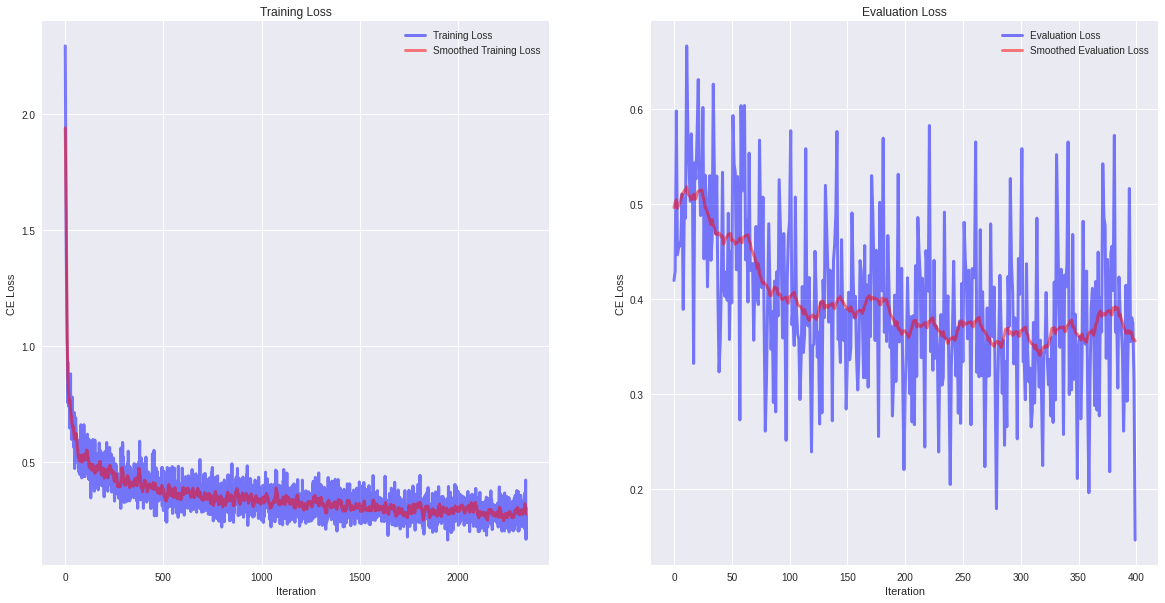

In [ ]:
plt.style.use('seaborn')
_, ax = plt.subplots(1, 2, figsize=(20,10))

ax[0].plot(train_loss, c="blue", label="Training Loss", linewidth=3, alpha=0.5)
ax[0].plot(smooth(train_loss, 10), c="red", label="Smoothed Training Loss", linewidth=3, alpha=0.5)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("CE Loss")
ax[0].set_title("Training Loss")

# since our evaluation loss is a nested list
train_eval_loss = np.array(train_eval_loss).flatten()
ax[1].plot(train_eval_loss, c="blue", label="Evaluation Loss", linewidth=3, alpha=0.5)
ax[1].plot(smooth(train_eval_loss, 30), c="red", label="Smoothed Evaluation Loss", linewidth=3, alpha=0.5)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("CE Loss")
ax[1].set_title("Evaluation Loss")
+
plt.show()


As we can see the Training loss drops quite heavily after the first few iterations but then only slighty declines past around 0.4 (probably overfits past that point). But the Evaluation loss fluctuates heavily, although by smoothing the curve we see that the evaluation loss also decreases.



 

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning:

The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



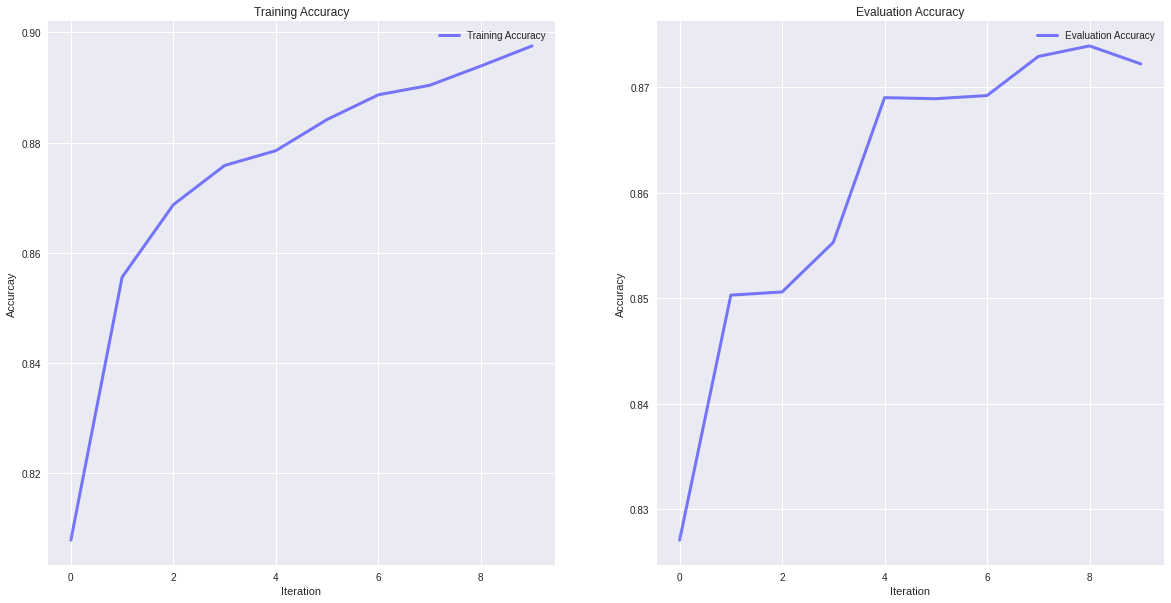

In [ ]:
plt.style.use('seaborn')
_, ax = plt.subplots(1, 2, figsize=(20,10))

ax[0].plot(train_acc, c="blue", label="Training Accuracy", linewidth=3, alpha=0.5)
ax[0].legend(loc="best")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("Accurcay")
ax[0].set_title("Training Accuracy")

ax[1].plot(train_eval_acc, c="blue", label="Evaluation Accuracy", linewidth=3, alpha=0.5)
ax[1].legend(loc="best")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Evaluation Accuracy")

plt.show()

As we can see with more training epochs the accuracy steadily increases while the evaluation accuracy increases but after the 4th iteration stagnates at around 87.5%.

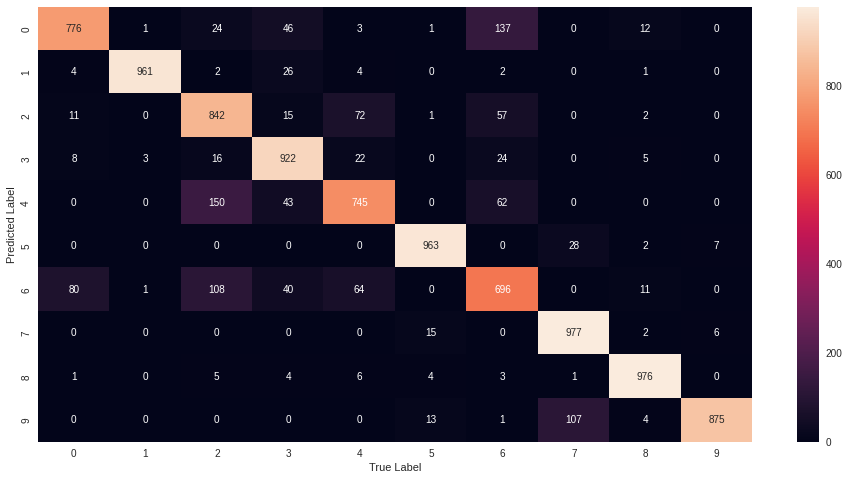

In [ ]:
plt.figure(figsize = (16,8))
conf_plot = sns.heatmap(confusion_matrix_eval, annot=True, fmt='g')
conf_plot.set(xlabel='True Label', ylabel='Predicted Label')
plt.show()

We get a good amount of true positives for every class, with the best being classes 1, 5, 8 with high numbers of true positives and a low amount of false positives. Some labels are harder to predict for our model like class 2 which is sometimes mistaken for class 4 and class 6, and class 6 which is sometimes mistaken for classes 0, 2, 3, 4.

Text(0.5, 1.0, 'Normed Gradient')

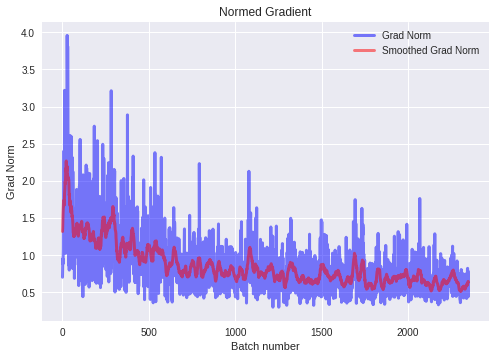

In [ ]:
_, ax = plt.subplots(1, 1)

ax.plot(all_grad_norms, c="blue", label="Grad Norm", linewidth=3, alpha=0.5)
ax.plot(smooth(all_grad_norms, 20), c="red", label="Smoothed Grad Norm", linewidth=3, alpha=0.5)
ax.legend(loc="best")
ax.set_xlabel("Batch number")
ax.set_ylabel("Grad Norm")
ax.set_title("Normed Gradient")

We can see the gradient decreases when weights are learned, although not as much as we expected and with a high fluctuation.

### Questions and/or doubts
- Direction of optuna optimization, apparently can be set to maximize or minimize, and also works for multi-objective optimization. Nevertheless, what to do when we just want to have for example both the loss and accuracy of every trial during the hyperparam optim, but only optimize on one of them?

- What are intermediate values in optuna? Are they used for the pruning?